In [215]:
import numpy as np 
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

import subprocess
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

nltk.data.path.append('/kaggle/input')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix 

import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing import sequence
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [216]:
data = pd.read_csv("/kaggle/input/tweets/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]


In [217]:
# start of dataset
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [218]:
# end of dataset
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [219]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [220]:
print('lenght of data is', len(data))

lenght of data is 1599999


In [221]:
data.shape    
# row by column

(1599999, 6)

In [222]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [223]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

In [224]:
np.sum(data.isnull().any(axis=1))

0

In [225]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   6


In [226]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   1599999


In [227]:
####
# Data Preprocessing
####

In [228]:
data = data[['text','label']]

In [229]:
data['label'][data['label']==4]=1

In [230]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [231]:
# slice code and keep only he first 20,000 rows
# taking one fourth data so we can run on our machine easily¶

data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [232]:
data = pd.concat([data_pos, data_neg])

In [233]:
data['text']=data['text'].str.lower()

In [234]:
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

In [235]:
stopwords_list = stopwords.words('english')

In [236]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [237]:
# Cleaning and removing the above stop words list from the tweet text¶

STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [238]:
# Cleaning and removing punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


In [239]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

In [240]:
# Cleaning and removing repeating characters¶

def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [241]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [242]:
# Cleaning and removing email

def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [243]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [244]:
# Cleaning and removing URL's

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [245]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [246]:
# Cleaning and removing Numeric numbers

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [247]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather god thing find none ones like come siz...
Name: text, dtype: object

In [248]:
# Getting tokenization of tweet text¶
data['text'] = data['text'].apply(' '.join)
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [249]:
data['text'].head()

799999    [l, o, v, e, h, e, a, l, t, h, u, a, n, d, p, ...
800000    [i, m, m, e, t, i, n, g, o, n, e, b, e, s, t, ...
800001    [d, a, r, e, a, l, s, u, n, i, s, a, k, i, m, ...
800002    [s, i, c, k, r, e, a, l, y, c, h, e, a, p, h, ...
800003    [l, o, v, e, s, b, r, o, k, l, y, n, e, f, e, ...
Name: text, dtype: object

In [250]:
# Applying Stemming

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [251]:
data['text'].head()

799999    [l, o, v, e, h, e, a, l, t, h, u, a, n, d, p, ...
800000    [i, m, m, e, t, i, n, g, o, n, e, b, e, s, t, ...
800001    [d, a, r, e, a, l, s, u, n, i, s, a, k, i, m, ...
800002    [s, i, c, k, r, e, a, l, y, c, h, e, a, p, h, ...
800003    [l, o, v, e, s, b, r, o, k, l, y, n, e, f, e, ...
Name: text, dtype: object

In [252]:

# Applying Lemmatizer

lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

In [253]:
data['text'].head()

799999    [l, o, v, e, h, e, a, l, t, h, u, a, n, d, p, ...
800000    [i, m, m, e, t, i, n, g, o, n, e, b, e, s, t, ...
800001    [d, a, r, e, a, l, s, u, n, i, s, a, k, i, m, ...
800002    [s, i, c, k, r, e, a, l, y, c, h, e, a, p, h, ...
800003    [l, o, v, e, s, b, r, o, k, l, y, n, e, f, e, ...
Name: text, dtype: object

In [254]:

# Separating input feature and label

X=data.text
y=data.label

In [255]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [256]:
sequences_matrix.shape

(40000, 500)

In [257]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [258]:
#######
# Implementing Tensorflow based model for training
#######

In [259]:
def tensorflow_based_model(): 
    inputs = Input(name='inputs',shape=(max_len,))          #step1
    layer = Embedding(2000,50)(inputs)                      #step2
    layer = LSTM(64)(layer)                                 #step3
    layer = Dense(256,name='FC1')(layer)                    #step4
    layer = Activation('relu')(layer)                       #step5
    layer = Dropout(0.5)(layer)                             #step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as only need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer)     #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #get final output value in the model for classification here
    return model 

In [260]:
model = tensorflow_based_model()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  

In [306]:
# training of model by feeding the training data
history = model.fit(X_train,Y_train,batch_size=100,epochs=10,validation_split=0.1)
print('Training finished !!')

Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6410 - loss: 0.6259 - val_accuracy: 0.6350 - val_loss: 0.6380
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6425 - loss: 0.6294 - val_accuracy: 0.6182 - val_loss: 0.6423
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6560 - loss: 0.6177 - val_accuracy: 0.6282 - val_loss: 0.6413
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6492 - loss: 0.6196 - val_accuracy: 0.6461 - val_loss: 0.6385
Epoch 5/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6545 - loss: 0.6142 - val_accuracy: 0.6421 - val_loss: 0.6361
Epoch 6/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6658 - loss: 0.6020 - val_accuracy: 0.6364 - val_loss: 0.6329
Epoch 7/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6609 - loss: 0.6058 - val_accuracy: 0.6379 - val_loss: 0.6324
Epoch 8/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6751 - loss: 0.5950 - val_accu

In [307]:
# Testing the Trained model on test data
accr1 = model.evaluate(X_test,Y_test) 
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6360 - loss: 0.6423
Test set
  Accuracy: 0.64


In [308]:
class model_import:
    def predict(self,text):
        sid = SentimentIntensityAnalyzer()
    
        score = sid.polarity_scores(text)

        if score['compound'] >= 0.05:
            return "Positive"
        elif score['compound'] <= -0.05:
            return "Negative"
        else:
            return "Neutral"

In [309]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 
#print(y_pred)

375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step




confusion matrix


[[4314 1695]
 [2653 3338]]




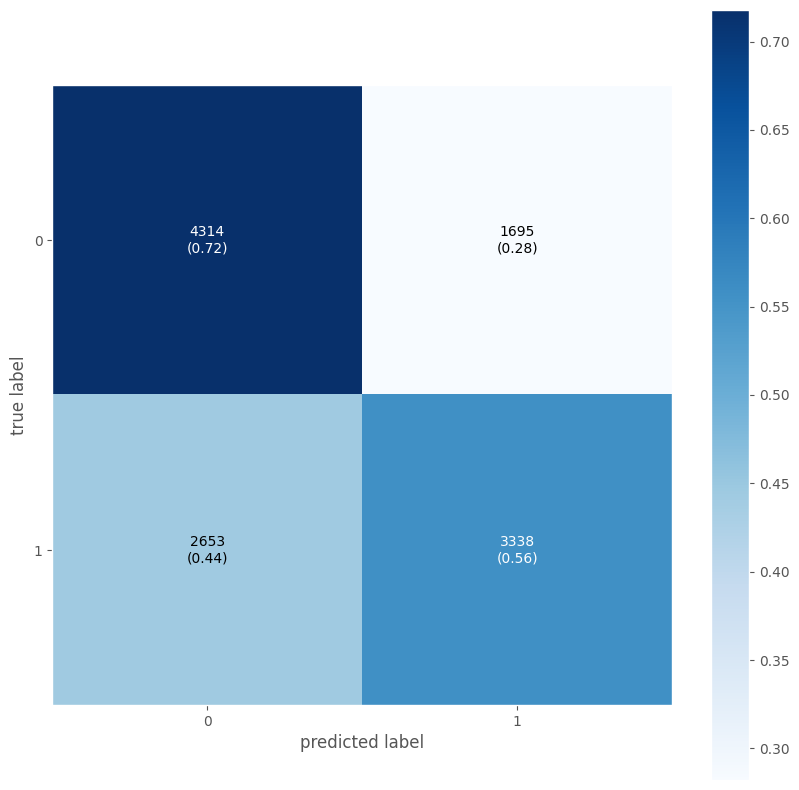

In [310]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

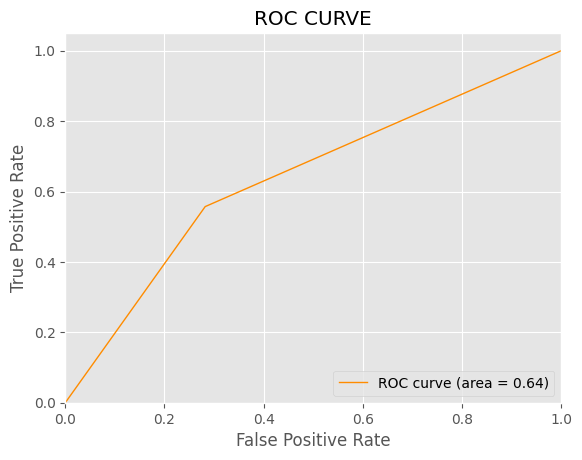

In [311]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [312]:
import pandas as pd

# Load the dataset
data = pd.read_csv("/kaggle/input/tweets/training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]

# Filter tweets that contain the word "hate"
hate_tweets = data[data['text'].str.contains("hate", case=False, na=False)]

# Assuming '0' represents negative sentiment in the 'label' column
negative_hate_tweets_count = hate_tweets[hate_tweets['label'] == 0].shape[0]

print(f"Number of negative tweets containing 'hate': {negative_hate_tweets_count}")

Number of negative tweets containing 'hate': 20250


In [321]:
trained_model = model_import()
user_input = input("Enter sentence: ")
prediction = trained_model.predict(user_input)
print(prediction)

Enter sentence:  it's really cold i feel like i'm in mount fuji


Positive
